<a href="https://colab.research.google.com/github/DarioMameli/DL_Assignments/blob/main/DL_Assignment2_Search.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DL Assignment 2
## Group 4
**AUTHORS**:
*   Dario Mameli [dario.mameli@ugent.be]
*   Àngel Masip LLopis [angel.masipllopis@ugent.be]
*   Michele Russo [michele.russo@ugent.be]



This notebook is to be intended as both report and code.

Running on google colab is suggested to make sure all required libraries and packages are present.

# Setup

Firstly let's setup the workspace

## GitHub
Let's clone the GitHub repository containing the dataset, models, hyperparameters and utils file.

In [ ]:
!git clone https://github.com/DarioMameli/DL_Ass2
import sys
# Add the repository to the path
sys.path.insert(1, '/content/DL_Ass2/')

Cloning into 'DL_Ass2'...
remote: Enumerating objects: 1480, done.
remote: Counting objects: 100% (29/29), done.
remote: Compressing objects: 100% (19/19), done.
remote: Total 1480 (delta 10), reused 29 (delta 10), pack-reused 1451
Receiving objects: 100% (1480/1480), 465.96 MiB | 14.85 MiB/s, done.
Resolving deltas: 100% (10/10), done.
Updating files: 100% (1454/1454), done.


## Pip Installs

In [ ]:
# Install the latest version of TensorFlow, which includes Keras (tf.keras)
#!pip install tensorflow --upgrade
!pip install keras --upgrade --quiet
!pip install keras-tuner --upgrade

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 6.4 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.15.0 requires keras<2.16,>=2.15.0, but you have keras 3.0.5 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.2/86.2 kB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 5.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283835 sha256=3ac859abe6d2cca712a6ffb4a9054ebafd80fae0dbb47cd57cbc5f8ea901a865
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.1/52.1 kB 1.8 MB/s eta 0:00:00


## Packages

Let's import all the necessary functions and packages

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import keras
from keras import regularizers
import matplotlib.gridspec as gridspec
from keras.datasets import fashion_mnist
from keras.models import Sequential
from keras.utils import to_categorical
import keras_tuner as kt
from keras import backend as backend
from keras.layers import (
    Input,
    Activation,
    BatchNormalization,
    Conv2D,
    Conv2DTranspose,
    Dense,
    Dropout,
    Flatten,
    GlobalAveragePooling2D,
    MaxPooling2D,
    UpSampling2D
)
from keras.optimizers import SGD, Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_curve, confusion_matrix, ConfusionMatrixDisplay
from dl_utils import plot_history
from dl_utils import load_or_build
from sklearn.metrics import confusion_matrix, classification_report, f1_score, precision_score, recall_score
import gdown
import zipfile
import os
from PIL import Image
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import tensorflow as tf
import keras.applications as app
from keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model, load_model
import gc
import json
from prettytable import PrettyTable
from keras import Model, ops

from skimage.segmentation import mark_boundaries
from sklearn.preprocessing import minmax_scale
from lime import lime_image
from tf_keras_vis.saliency import Saliency
from tf_keras_vis.utils import normalize
from tf_keras_vis.utils.scores import CategoricalScore

## Global Variables

First of all we set the seed for reproducibility of the results, and the training flags.

In [ ]:
SEED=33

# Load data

Load the dataset

In [ ]:
# Define the paths for X and y
X = []
y = []

# Iterate through the extracted folder
for root, dirs, files in os.walk('/content/DL_Ass2/images'):
    for folder_name in dirs:
        folder_path = os.path.join(root, folder_name)

        # Sort the list of files to ensure a consistent order
        #file_list = sorted(os.listdir(folder_path))

        # Iterate through sorted images in each folder
        for image_file in os.listdir(folder_path):
            image_path = os.path.join(folder_path, image_file)

            # Load the image and convert it to a numpy array if needed
            img = Image.open(image_path)
            img_array = np.array(img)
            X.append(img)
            y.append(folder_name)

Preprocess the feature vectors:


*   Resize images to fit with the pretrained networks
*   **DO NOT** normalize data values as the pretrained networks expects input values in the range [0, 255]



In [ ]:
def resize_images(images, target_size):
  # Resizing all the images
  resized_images = []
  # Resize each image to the target size using LANCZOS resampling
  for img in images:
      resized_img = img.resize(target_size, Image.LANCZOS)
      resized_images.append(resized_img)
  # Convert the list of resized images to a NumPy array
  images_array = np.array([np.array(img) for img in resized_images])

  return images_array

In [ ]:
# Define the target size
target_size = (224, 224)

# Resize images
resized_X = resize_images(X, target_size)

# Convert to numpy array
X_array = np.array([np.array(img) for img in resized_X])

# Normalization
# X_array = X_array.astype("float32")
# X_array /= 255

Show a few sample images with literal type label

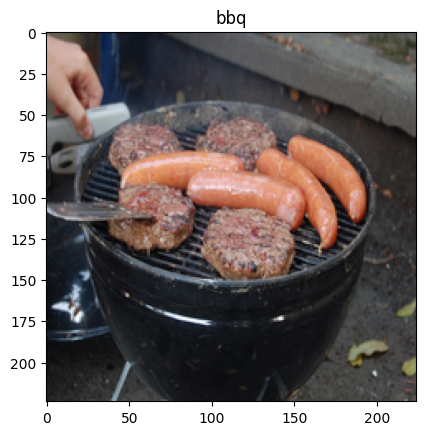

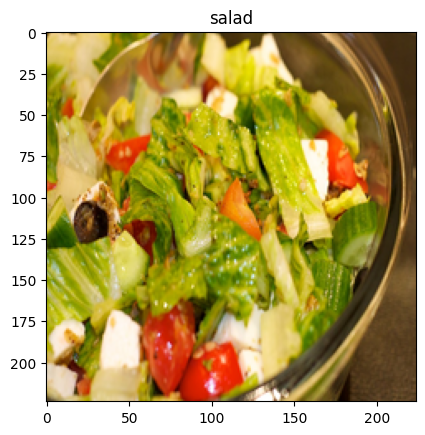

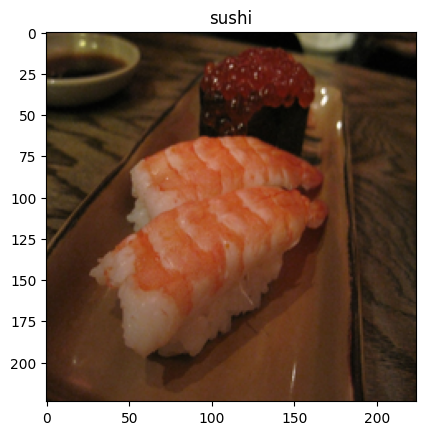

In [ ]:
plt.imshow(X_array[1000])
plt.title(y[1000])
plt.show()
plt.imshow(X_array[500])
plt.title(y[500])
plt.show()
plt.imshow(X_array[0])
plt.title(y[0])
plt.show()

Preprocess the labels (one-hot encodings)

In [ ]:
# Convert y to numerical labels using LabelEncoder from sklearn
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Transform to one hot encodings
min = np.min(y)
max = np.max(y)
print(min, max)
num_classes = max + 1
y = to_categorical(y, num_classes)

print("First label is now = ", y[0])

0 4
First label is now =  [0. 0. 0. 0. 1.]


## Testing and validation data split
Split training data into training and validation data, so that a full training-validation-test split is obtained, for maximizing the generalization performance. In this notebook, however, we really only need training and validation.

In [ ]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_array, y, test_size=0.1, shuffle=True, random_state=SEED)

# Split again training data into training and validation
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, shuffle=True,  random_state=SEED) # for reproducibility

print(X_train.shape[0], "train samples")
print(X_val.shape[0], "validation samples")
print(X_test.shape[0], "test samples")

1038 train samples
260 validation samples
145 test samples


#Our Search Model







The search model is a class extending the HyperModel, that performs search of hyperparameters on fine-tuned pretrained networks.

The fine-tuning follows the same principle as explained in the Training&Eval notebook, with the exception that the MLP head has fewer layers (and thus fewer trainable parameters), with the goal of speeding up the search and limiting the RAM usage. We are therefore going to (strongly) assume that the same best parameters found here are going to apply to the deeper model as well.

The hyperparameters we tune are:
*   Number of neurons in the dense layers
*   Dropout rate (for regularization)
*   Learning rate

Notice that the batch size is left constant, and equal to the one using in the Training&Eval notebook.

We use a relatively small search space as the models are quite heavy and we wouldn't be able to complete the search otherwise.

In [ ]:
class MyCNNModel(kt.HyperModel):
    def __init__(self, model_name, num_classes=5, loss="categorical_crossentropy"):
        self.loss = loss
        self.model_name = model_name
        self.num_classes = num_classes

    def build(self, hp):
        model = self.build_CNN(hp)
        return model

    def build_CNN(self, hp):
        hp_units = hp.Choice('units', values=[16, 32, 64])
        hp_learning_rate = hp.Choice('learning_rate', values=[1e-3, 1e-4, 1e-5])
        hp_dropout_rate = hp.Choice('dropout_rate', values=[0.0, 0.2, 0.4, 0.6])

        model = self.build_CNN_hp(
            hp_units=hp_units,
            hp_learning_rate=hp_learning_rate,
            hp_dropout_rate=hp_dropout_rate
        )
        return model

    def build_CNN_hp(self, hp_units, hp_learning_rate, hp_dropout_rate):

        # Build the base
        if self.model_name == 'ResNet50':
          base = app.ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
        elif self.model_name == 'EfficientNetB0':
          base = app.EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
        elif self.model_name == "DenseNet121":
          base = app.DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
        elif self.model_name == "EfficientNetV2B0":
          base = app.InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
        elif self.model_name == "MobileNet":
          base = app.MobileNet(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

        for layer in base.layers:
            layer.trainable = False

        # Build the head
        x = base.output
        x = GlobalAveragePooling2D()(x)
        x = BatchNormalization()(x)
        x = Dense(hp_units*2, activation='relu')(x)
        x = Dropout(hp_dropout_rate)(x)
        x = BatchNormalization()(x)
        x = Dense(hp_units, activation='relu')(x)
        x = Dropout(hp_dropout_rate)(x)
        x = BatchNormalization()(x)
        head = Dense(units=self.num_classes, activation='softmax')(x)

        # Merge base and head
        model = Model(inputs=base.input, outputs=head)
        model.compile(loss=self.loss,
                           optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate),
                           metrics=['accuracy'])
        return model


    def fit(self, hp, model, *args, **kwargs):
        return model.fit(
            X_train, y_train, batch_size=128,
            validation_data=(X_val, y_val)
        )


Here we define the tuner and the model which is targetted by the search.

The tuner is the BayesianOptimization, which is able to overcome the limitations of random sampling based techniques by taking into account the history of the tried combinations, and then through a gaussian process estimate the next best hyperparameters.

However, Hyperband has also been shown to work well, and in fact the main reason why this tuner is chosen over Hyperband is because of the possibility of setting a maximum number of trials. We will set a low number because of the heavy toll the instantiation of fine-tuned models takes on the limited RAM availability, which is why this notebook has been separated in the first place.

Additionally, we have noticed how the fit function of the underlying HyperModel causes heavily impactful memory leaks, making it impossible to run additional code sections.
(see also https://github.com/keras-team/keras-tuner/issues/395).

From the Training&Eval notebook we have seen that EfficientNetB0 is the best performing model with the standard parameters, hence this is the model that we seek to optimize by performing hyperparameters tuning.

In [ ]:
BEST_MODEL_NAME = "EfficientNetB0"

tuner = kt.BayesianOptimization(
    hypermodel=MyCNNModel(BEST_MODEL_NAME, num_classes),
    objective='val_accuracy',
    #overwrite=True,
    max_trials=6,
    directory='my_cnn_tuning',
    project_name='my_cnn_tuning',
    seed=SEED # for reproducibility of the results
)

# Summarize the search space
tuner.search_space_summary()


Reloading Tuner from my_cnn_tuning/my_cnn_tuning/tuner0.json
Search space summary
Default search space size: 3
units (Choice)
{'default': 16, 'conditions': [], 'values': [16, 32, 64], 'ordered': True}
learning_rate (Choice)
{'default': 0.001, 'conditions': [], 'values': [0.001, 0.0001, 1e-05], 'ordered': True}
dropout_rate (Choice)
{'default': 0.0, 'conditions': [], 'values': [0.0, 0.2, 0.4, 0.6], 'ordered': True}


# Search


Let's now perform the search and save the hyperparameters found, in order to use them in the Training&Eval notebook.

Notice how the RAM use blows up.

In [ ]:
# Early stop to prevent overfitting
stop_early = tf.keras.callbacks.EarlyStopping(
  monitor="val_loss",
  min_delta=0,
  patience=5,
  verbose=0,
  mode="auto",
  baseline=None,
  restore_best_weights=True,
  start_from_epoch=3,
)

# Perform the search
tuner.search(X_train, y_train, validation_data=(X_val, y_val), callbacks=[stop_early])

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Define the file name where you want to save the hyperparameters
file_name = "/content/DL_Ass2/best_hps.json"

# Serialize the hyperparameters to JSON format and save them to the file
with open(file_name, "w") as f:
    json.dump(best_hps.values, f)

print("Best Hyperparameters found:")
print(best_hps.values)

Trial 8 Complete [00h 02m 36s]
val_accuracy: 0.25

Best val_accuracy So Far: 0.8307692408561707
Total elapsed time: 00h 21m 23s
Best Hyperparameters found:
{'units': 64, 'learning_rate': 0.001, 'dropout_rate': 0.6}


# Memory Leaks

We can see how the deallocation of the tuner does not seem to produce any decrease in the RAM usage. In fact, by printing the local variables and sorting them by memory use, we see that the sum of the sizes is much smaller than the total amount of memory allocated.

Therefore, since there is no way to manually deallocate that memory, and the garbage collector call does not seem to solve the issue, we have memory leak occurring. That is why we have split the code into two separate files.

In [ ]:
# Try to remove previously used variable to free up space if present
if 'tuner' in locals():
    del tuner
    gc.collect()

# Following code courtesy of:
# (https://stackoverflow.com/questions/24455615/python-how-to-display-size-of-all-variables)
# Shows all of the local variable's memory usage
import sys
def sizeof_fmt(num, suffix='B'):
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.1f %s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f %s%s" % (num, 'Yi', suffix)

for name, size in sorted(((name, sys.getsizeof(value)) for name, value in list(
                          locals().items())), key= lambda x: -x[1])[:10]:
    print("{:>30}: {:>8}".format(name, sizeof_fmt(size)))

                     resized_X: 207.1 MiB
                       X_array: 207.1 MiB
                       X_train: 149.0 MiB
                         X_val: 37.3 MiB
                        X_test: 20.8 MiB
                     img_array:  1.2 MiB
                       y_train: 40.7 KiB
                             X: 12.4 KiB
                         y_val: 10.3 KiB
                        y_test:  5.8 KiB
